In [1]:
import sys
sys.path.append("/kaggle/input/updated-unet3d")

In [2]:
from updated_unet3d import UNet
import pytorch_lightning as pl
import torch

# Your LightningModule class
class Segmenter(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, data):

        return self.model(data)

    def training_step(self, batch, batch_idx):
        img = batch["CT"]  # ["data"] already a tensor
        mask = batch["Label"][:, 0]  # remove channel dim
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Loss", loss)    # you could add on_step=False, on_epoch=True to log once per epoch.
        return loss

    def validation_step(self, batch, batch_idx):
        img = batch["CT"]  # ["data"]already a tensor
        mask = batch["Label"][:, 0]  # remove channel dim
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Loss", loss)
        return loss

    def configure_optimizers(self):
        return [self.optimizer]

In [3]:
# Load checkpoint
ckpt_path = "/kaggle/input/liver-tumor-seg-logs/logs/lightning_logs/version_0/checkpoints/epoch=9-step=2100.ckpt"
model = Segmenter.load_from_checkpoint(ckpt_path)

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")         # NVIDIA GPU
else:
    device = torch.device("cpu")          # Default to CPU

print("Using device:", device)

# Send model to device
model = model.to(device)
model.eval()

Using device: cuda


Segmenter(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): ReLU(inplace=True)
        (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(


In [5]:
%pip install celluloid
%pip install torchio

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 

In [5]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera
from IPython.display import HTML

In [6]:
from pathlib import Path

import torchio as tio

In [7]:
val_path = Path("/kaggle/input/liversegtestimages/")

In [8]:
subject_path_list = list(val_path.glob("liver_*"))
subject_path_list[0].name

'liver_174.nii'

In [9]:
len(subject_path_list)

70

In [10]:
subjects = []

for subject_path in subject_path_list:

    # sanity check
    if isinstance(subject_path, dict):
        raise TypeError(f"subject_path is a dictionary! {subject_path}")

    subject = tio.Subject(
        CT=tio.ScalarImage(subject_path)    # lazy load
    )
    
    subjects.append(subject)

In [11]:
print(type(subjects[0]["CT"]), subjects[0]["CT"])

for subject in subjects:
    # Check orientation
    assert subject["CT"].orientation == ("R", "A", "S"), \
        f"CT orientation is wrong for subject: {subject}"

    # Check that CT is a ScalarImage
    assert isinstance(subject["CT"], tio.ScalarImage), \
        f"CT is not a ScalarImage for subject: {subject}"

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 512, 512, 269); spacing: (0.60, 0.60, 1.50); orientation: RAS+; path: "/kaggle/input/liversegtestimages/liver_174.nii")


In [12]:
process = tio.Compose([                                 # Deterministic: Things inside Compose happen the same way every time you call it.
    tio.ToCanonical(),                     # step 1: fix orientation
    tio.Resample(target = 'CT'),                         # step 2: align all images to same grid
    tio.RescaleIntensity((-1, 1)),          # step 3: normalize intensity
    tio.CropOrPad((256, 256, 200)),         # step 4: now safe to crop/pad
])

val_transform = process

In [13]:
val_dataset = tio.SubjectsDataset(subjects[:], transform = val_transform)

In [25]:
IDX = 9
imgs = val_dataset[IDX]["CT"]["data"]
subjects[IDX]["CT"]["data"]

tensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

         [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -

In [26]:
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8,8,8))

In [27]:
aggregator = tio.inference.GridAggregator(grid_sampler)

In [28]:
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size = 4)

In [29]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch["CT"]["data"].to(device)
        locations = patches_batch[tio.LOCATION]
        pred = model(input_tensor)
        aggregator.add_batch(pred, locations)

In [30]:
output_tensor = aggregator.get_output_tensor()

In [31]:
import matplotlib.pyplot as plt
import numpy as np

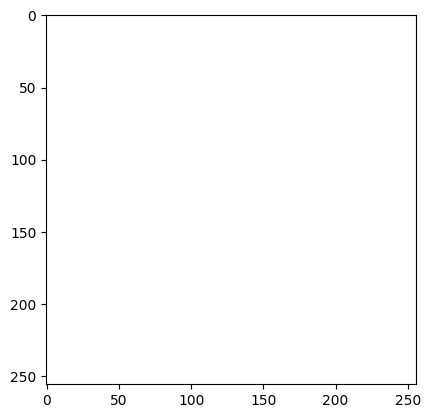

In [38]:
fig = plt.figure()
camera = Camera(fig)
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[-1], 2):
    plt.imshow(imgs[0, :, :, i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i] == 0, pred[:,:,i])
    plt.imshow(mask_, alpha = 0.5, cmap = "autumn")
    camera.snap()

animation = camera.animate()

In [39]:
HTML(animation.to_html5_video())